In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

[INFO][corrections] Numba not available, reverting to Numpy


Set up the filters.  "numstds" is the number of standard deviations to take from the median.

Plot some diagnostics

In [3]:
def get_XAS(scan_name, DIR, DIR_json, numstds, minIzero):
    #numstds = 2
    #minIzero = 0.015

    json_file = DIR_json + scan_name + "_scan_info.json"
    print (json_file)

    with open(json_file) as file:
        data = json.load(file)
    numFiles = len(data['scan_files'])

    print ("Processing",numFiles,"files")

    DataFluo_pump_norm_total = np.empty(0)
    DataFluo_unpump_norm_total = np.empty(0)
    err_DataFluo_pump_total = np.empty(0)
    err_DataFluo_unpump_total = np.empty(0)

    IzeroFEL_pump_original_total = np.empty(0)
    IzeroFEL_pump_total = np.empty(0)
    IzeroFEL_unpump_original_total = np.empty(0)
    IzeroFEL_unpump_total = np.empty(0)

    DataFluo_pump_original_total = np.empty(0)
    DataFluo_pump_total = np.empty(0)
    DataFluo_unpump_original_total = np.empty(0)
    DataFluo_unpump_total = np.empty(0)

    delay_mm = np.empty(0)
    iZero = np.empty(0)
    

    for i in range(0,numFiles):
    #for i in range(0,1):
        filename = str(data['scan_files'][i][0])
        filename = DIR + os.path.basename(filename)
        exists = os.path.isfile(filename)
        if not exists:
            print("No such file")
        elif exists: #Do we need this 39?
#             print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
            (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, delay, _, _, _) = \
                load_PumpProbe_events(filename, channel_delay_SH)

            IzeroFEL_pump_original = IzeroFEL_pump.copy()
            IzeroFEL_unpump_original = IzeroFEL_unpump.copy()

            IzeroFEL_pump_original_total = np.append(IzeroFEL_pump_original_total, IzeroFEL_pump_original)
            IzeroFEL_unpump_original_total = np.append(IzeroFEL_unpump_original_total, IzeroFEL_unpump_original)

            DataFluo_pump_original_total = np.append(DataFluo_pump_original_total, DataFluo_pump)
            DataFluo_unpump_original_total = np.append(DataFluo_unpump_original_total, DataFluo_unpump)

            IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
            IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))

            conditionPumpMax = IzeroFEL_pump < IzeroMedian+numstds*IzeroSTD
            conditionPumpMin = IzeroFEL_pump > IzeroMedian-numstds*IzeroSTD
            conditionPumpLow = IzeroFEL_pump > minIzero

            conditionUnPumpMax = IzeroFEL_unpump < IzeroMedian+numstds*IzeroSTD
            conditionUnPumpMin = IzeroFEL_unpump > IzeroMedian-numstds*IzeroSTD
            conditionUnPumpLow = IzeroFEL_unpump > minIzero

            condIzeroPump = conditionPumpMax & conditionPumpMin & conditionPumpLow
            condIzeroUnPump = conditionUnPumpMax & conditionUnPumpMin & conditionUnPumpLow

            IzeroFEL_pump = IzeroFEL_pump[condIzeroPump]
            IzeroFEL_unpump = IzeroFEL_unpump[condIzeroUnPump]

            IzeroFEL_pump_total = np.append(IzeroFEL_pump_total, IzeroFEL_pump)
            IzeroFEL_unpump_total = np.append(IzeroFEL_unpump_total, IzeroFEL_unpump)

            DataFluo_pump = DataFluo_pump[condIzeroPump]
            DataFluo_unpump = DataFluo_unpump[condIzeroUnPump]

            DataFluo_pump_total = np.append(DataFluo_pump_total, DataFluo_pump)
            DataFluo_unpump_total = np.append(DataFluo_unpump_total, DataFluo_unpump)

            DataFluo_pump_norm = DataFluo_pump/IzeroFEL_pump
            DataFluo_unpump_norm = DataFluo_unpump/IzeroFEL_unpump

            DataFluo_pump_norm_total = np.append(DataFluo_pump_norm_total, DataFluo_pump_norm.mean())
            DataFluo_unpump_norm_total = np.append(DataFluo_unpump_norm_total, DataFluo_unpump_norm.mean())
            err_DataFluo_pump_total = np.append(err_DataFluo_pump_total, DataFluo_pump_norm.std()/np.sqrt(DataFluo_pump_norm.size))
            err_DataFluo_unpump_total = np.append(err_DataFluo_unpump_total, DataFluo_unpump_norm.std()/np.sqrt(DataFluo_unpump_norm.size))


            
            delay = [x for x in delay if (np.abs(x) > 0)]
            delay_mm = np.append(delay_mm, np.mean(delay))
            iZero = [x for x in iZero if (np.abs(x) > 0)]
            iZero = np.append(iZero, np.mean(IzeroFEL_pump_total))
            
    plt.figure()
    _, bins, _ = plt.hist(IzeroFEL_pump_original_total, 100, label = 'unfiltered')
    _ = plt.hist(IzeroFEL_pump_total, bins, rwidth = .5, label = 'filtered')
    plt.title('Izero, pumped')
    plt.legend()

    plt.figure()
    _, bins, _ = plt.hist(IzeroFEL_unpump_original_total, 100, label = 'unfiltered')
    _ = plt.hist(IzeroFEL_unpump_total, bins, rwidth = .5, label = 'filtered')
    plt.title('Izero, unpumped')
    plt.legend()
    
    plt.figure()
    plt.scatter(IzeroFEL_pump_original_total, DataFluo_pump_original_total)
    plt.scatter(IzeroFEL_pump_total, DataFluo_pump_total)
    plt.title('Izero, pumped')
    plt.xlabel('I0')
    plt.ylabel('Absorption')

    delay_mm = delay_mm[1:]
    DataFluo_pump_norm_total = DataFluo_pump_norm_total[1:]
    DataFluo_unpump_norm_total = DataFluo_unpump_norm_total[1:]
    iZero =iZero[1:]
    
    plt.figure()
    plt.plot(np.array(delay_mm))
    
    plt.figure()
    plt.plot(np.array(delay_mm), DataFluo_pump_norm_total,label='Pumped')
    plt.plot(np.array(delay_mm), DataFluo_unpump_norm_total,label='UnPumped')
    plt.plot(np.array(delay_mm), np.array(iZero)*100,label="I_zero_Arb")
    plt.xlabel('delay (mm)')
    plt.ylabel('absorption')
    plt.title('XAS_'+ scan_name)
    plt.legend()


    return iZero, delay_mm, DataFluo_unpump_norm_total, DataFluo_pump_norm_total
        

/sf/alvra/data/p17983/res/scan_info/RuDimerACN_timescan_029_scan_info.json
Processing 23 files


<IPython.core.display.Javascript object>


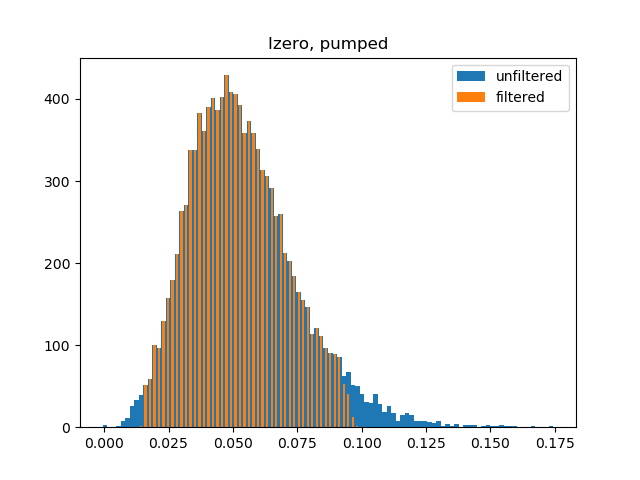

<IPython.core.display.Javascript object>


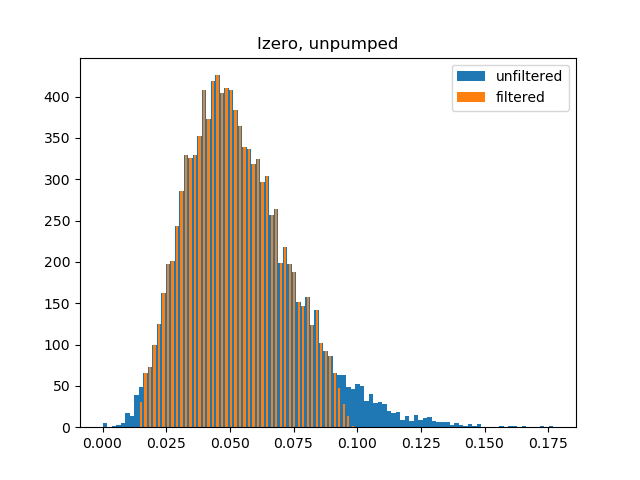

<IPython.core.display.Javascript object>


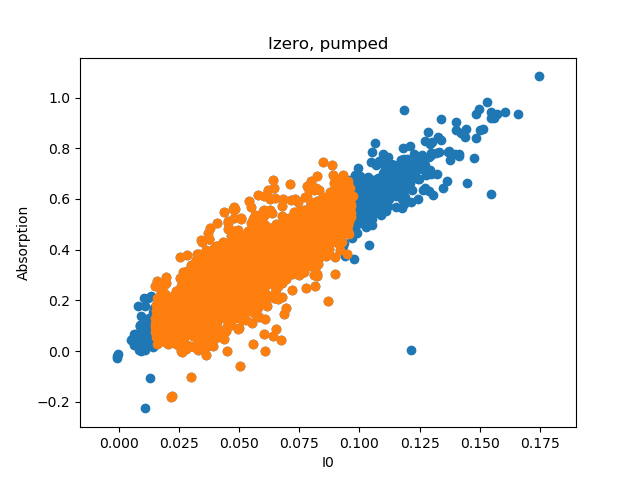

<IPython.core.display.Javascript object>


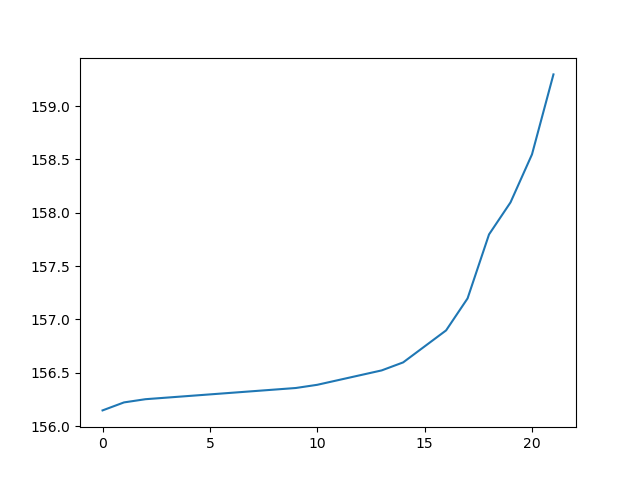

<IPython.core.display.Javascript object>


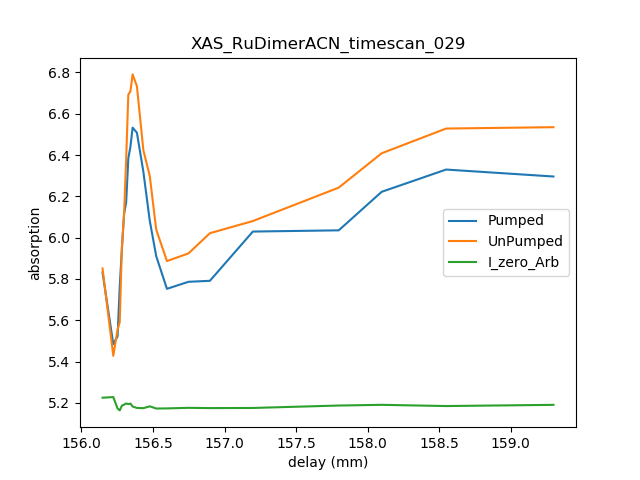

In [4]:
ploton = True


numstds = 2
minIzero = 0.015

scan_name = "RuDimerACN_timescan_029"
DIR = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

(iZero, delay_mm, DataFluo_unpump_norm_total, DataFluo_pump_norm_total) = get_XAS(scan_name, DIR, DIR_json, numstds, minIzero)

diff = DataFluo_pump_norm_total - DataFluo_unpump_norm_total

# convert delays to ps
time_zero_mm = 160
delay_ps = 1e12*(delay_mm - time_zero_mm)*2*1e-3/(3e8)

delays = np.array(delay_ps)




<IPython.core.display.Javascript object>


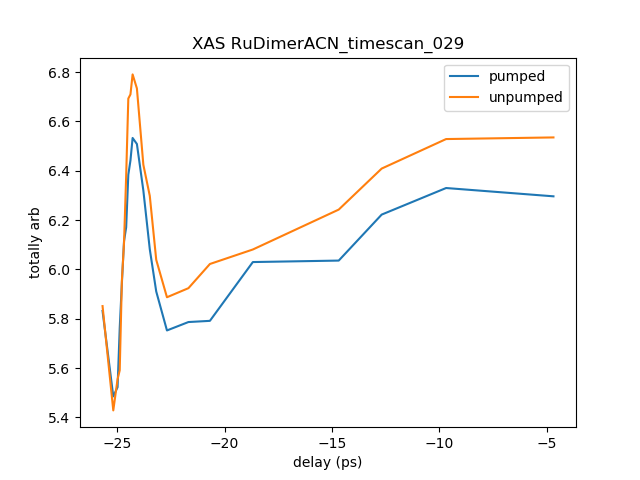

<IPython.core.display.Javascript object>


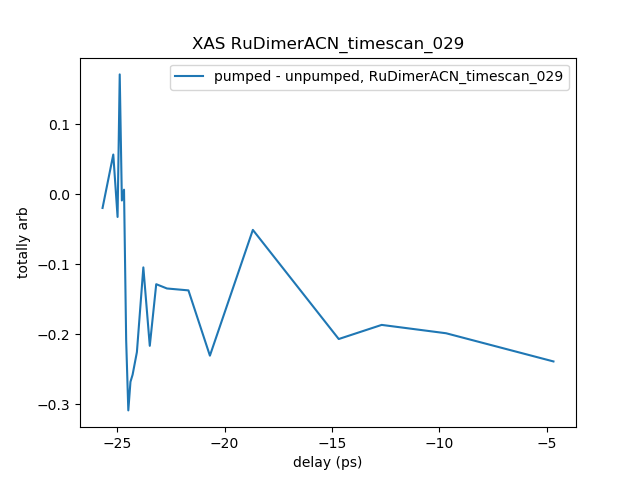

Text(0.5, 0, 'delay (ps)')

In [5]:
plt.figure()
plt.plot(delays, DataFluo_pump_norm_total, label='pumped')
plt.plot(delays, DataFluo_unpump_norm_total, label='unpumped') 
plt.legend()
plt.title('XAS ' + scan_name)
plt.ylabel('totally arb')
plt.xlabel('delay (ps)')

plt.figure()
plt.plot(delays, diff, label='pumped - unpumped, ' + scan_name) 
plt.legend()
plt.title('XAS ' + scan_name)
plt.ylabel('totally arb')
plt.xlabel('delay (ps)')